In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [3]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding="valid")
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="valid")
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding="valid")
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=43264, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=100)
        
    def forward(self, x):
        exit_outputs = []
        x = self.conv1(x)
        x = F.relu(x)
        exit_outputs.append(x)
        x = self.conv2(x)
        x = F.relu(x)
        exit_outputs.append(x)
        x = self.conv3(x)
        x = F.relu(x)
        exit_outputs.append(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x, exit_outputs

In [4]:
class IndividualEEModel(nn.Module):
    def __init__(self, in_features):
        super(IndividualEEModel, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=in_features, out_features=100)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [5]:
class GeneralEEModel(nn.Module):
    def __init__(self):
        super(GeneralEEModel, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.fc1 = nn.Linear(in_features=14400, out_features=32)
        self.fc2 = nn.Linear(in_features=25088, out_features=32)
        self.fc3 = nn.Linear(in_features=10816, out_features=32)
        self.fcs = [self.fc1, self.fc2, self.fc3]
        self.flatten = nn.Flatten()
        self.fc4 = nn.Linear(in_features=32, out_features=100)
    
    def forward(self, x):
        fc_outs = []
        batch_size = x[0].shape[0]
        for i, x_ in enumerate(x):
            x_ = self.pool(x_)
            x_ = self.flatten(x_)
            x_ = self.fcs[i](x_)
            x_ = F.relu(x_)
            fc_outs.append(x_)
        xx = []
        for i in range(32):
            for j in range(len(fc_outs)):
                xx.append(torch.reshape(fc_outs[j][:, i], (batch_size, 1)))
        x = torch.cat(xx, dim=1)
        x = torch.unsqueeze(x, 1)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.fc4(x)
        return x

In [6]:
def simulate_exit(x, choice=None):
    if choice:
        choice = choice
    else:
        choice = np.random.choice(np.arange(0, 3), p=[0.34, 0.33, 0.33])
    batch_size = x[0].shape[0]
    reshaped_output = []
    for i in range(3):
        if i <= choice :
            reshaped_output.append(x[i])
        else:
            reshaped_output.append(torch.zeros_like(x[i]))
    return reshaped_output, choice

In [7]:
def train(baseline, exit_model, layer, epochs, criterion, 
          optimizer, train_loader, val_loader, model_name, gen_ee=False):
    best_val_epoch, best_val_loss = 0, 1e6
    break_flag = 0
    for epoch in range(epochs):  # loop over the dataset multiple times
        exit_model.train()
        t_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            t_loss += loss.item()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        t_loss = t_loss / (i+1)
        t_loss = round(t_loss, 5)
        t_acc = round(100*(correct / total), 5)
        exit_model.eval()
        v_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(val_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        v_loss = v_loss/(i+1)
        v_loss = round(v_loss, 5)
        v_acc = round(100*(correct / total), 5)
        if v_loss <= best_val_loss:
            torch.save(exit_model.state_dict(), model_name)
            best_val_epoch = epoch + 1
            best_val_loss = v_loss
            break_flag = 0
        else:
            break_flag += 1
        print(f'Epoch[{epoch+1}]: t_loss: {t_loss} t_acc: {t_acc} v_loss: {v_loss} v_acc: {v_acc}')
        if break_flag >19 :
            break
    print('Finished Training')
    print('Best model saved at epoch: ', best_val_epoch)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
dataset = CIFAR100(root='./data', download=True, transform=ToTensor())
test_dataset = CIFAR100(root='./data', train=False, transform=ToTensor())

Files already downloaded and verified


In [10]:
batch_size=128
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4)

In [11]:
baseline = Baseline().to(device)
baseline.load_state_dict(torch.load("cifar100_baseline_s.h5", map_location='cpu'))
ee_model_name = "cifar100_ee_s.h5"
baseline.eval()

Baseline(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=43264, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=100, bias=True)
)

In [12]:
in_features = []
m = nn.MaxPool2d(kernel_size=2)
f = nn.Flatten()
_, outs = baseline(torch.randn(2, 3, 32, 32).to(device))
for out in outs:
    xx = f(m(out))
    in_features.append(xx.shape[1])

In [13]:
result_dict = {}
result_dict["accuracy"] = []
for ii, in_feature in enumerate(in_features):
    print(f'Training for exit layer: {ii+1}')
    precisions, recall, f1 = [], [], []
    learning_rate = 1e-3
    exit_model = IndividualEEModel(in_features=in_feature).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(exit_model.parameters(), lr=1e-3, momentum=0.9)
    epochs = 100
    ee_model_name = "ind_ee_cifar100_s.h5"
    train(baseline, exit_model, ii, epochs, criterion, optimizer, train_loader, val_loader, ee_model_name)
    exit_model.load_state_dict(torch.load(ee_model_name, map_location='cpu'))
    exit_model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): 
        true_y, pred_y = [], []
        for i, data in enumerate(test_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            outputs = exit_model(outs[ii])
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_y = pred_y + list(predicted.detach().cpu().numpy())
            true_y = true_y + list(labels.detach().cpu().numpy())
        report = classification_report(true_y, pred_y, output_dict=True)
        result_dict["accuracy"].append(report["accuracy"])
        for i, (key, value) in enumerate(report.items()):
            if i < 10:
                precisions.append(value['precision'])
                recall.append(value['recall'])
                f1.append(value['f1-score'])
        result_dict[ii] = {
            'precision': precisions,
            'recall': recall,
            'f1': f1,
            'conf_mat': confusion_matrix(true_y, pred_y)
        }

Training for exit layer: 1
Epoch[1]: t_loss: 4.2271 t_acc: 8.56444 v_loss: 3.98917 v_acc: 13.2
Epoch[2]: t_loss: 3.86024 t_acc: 15.00667 v_loss: 3.80458 v_acc: 15.58
Epoch[3]: t_loss: 3.70587 t_acc: 17.64667 v_loss: 3.69053 v_acc: 17.62
Epoch[4]: t_loss: 3.60703 t_acc: 19.42222 v_loss: 3.61936 v_acc: 18.54
Epoch[5]: t_loss: 3.53371 t_acc: 20.67111 v_loss: 3.56962 v_acc: 19.42
Epoch[6]: t_loss: 3.47605 t_acc: 21.78 v_loss: 3.52211 v_acc: 20.1
Epoch[7]: t_loss: 3.42556 t_acc: 22.71556 v_loss: 3.47946 v_acc: 21.32
Epoch[8]: t_loss: 3.38401 t_acc: 23.46889 v_loss: 3.45514 v_acc: 21.18
Epoch[9]: t_loss: 3.34592 t_acc: 24.20222 v_loss: 3.41924 v_acc: 21.92
Epoch[10]: t_loss: 3.31209 t_acc: 24.65333 v_loss: 3.39899 v_acc: 22.6
Epoch[11]: t_loss: 3.28083 t_acc: 25.19556 v_loss: 3.37327 v_acc: 22.96
Epoch[12]: t_loss: 3.25299 t_acc: 26.09778 v_loss: 3.36306 v_acc: 22.72
Epoch[13]: t_loss: 3.22646 t_acc: 26.37556 v_loss: 3.33954 v_acc: 23.72
Epoch[14]: t_loss: 3.20202 t_acc: 26.71333 v_loss: 3.3

Epoch[15]: t_loss: 2.53163 t_acc: 38.78222 v_loss: 2.94604 v_acc: 29.2
Epoch[16]: t_loss: 2.5042 t_acc: 39.39778 v_loss: 2.94997 v_acc: 29.52
Epoch[17]: t_loss: 2.48122 t_acc: 40.05111 v_loss: 2.94357 v_acc: 29.32
Epoch[18]: t_loss: 2.45761 t_acc: 40.54444 v_loss: 2.93066 v_acc: 29.68
Epoch[19]: t_loss: 2.43554 t_acc: 40.93333 v_loss: 2.92455 v_acc: 30.06
Epoch[20]: t_loss: 2.41687 t_acc: 41.31556 v_loss: 2.92223 v_acc: 29.94
Epoch[21]: t_loss: 2.39506 t_acc: 41.83111 v_loss: 2.92178 v_acc: 29.94
Epoch[22]: t_loss: 2.37707 t_acc: 42.28889 v_loss: 2.90776 v_acc: 30.0
Epoch[23]: t_loss: 2.36087 t_acc: 42.52667 v_loss: 2.89805 v_acc: 31.1
Epoch[24]: t_loss: 2.34092 t_acc: 43.02444 v_loss: 2.9138 v_acc: 29.84
Epoch[25]: t_loss: 2.32433 t_acc: 43.40889 v_loss: 2.89494 v_acc: 30.36
Epoch[26]: t_loss: 2.30746 t_acc: 43.86 v_loss: 2.89914 v_acc: 30.7
Epoch[27]: t_loss: 2.29088 t_acc: 44.26889 v_loss: 2.88566 v_acc: 30.7
Epoch[28]: t_loss: 2.27698 t_acc: 44.57556 v_loss: 2.89218 v_acc: 30.36
Ep

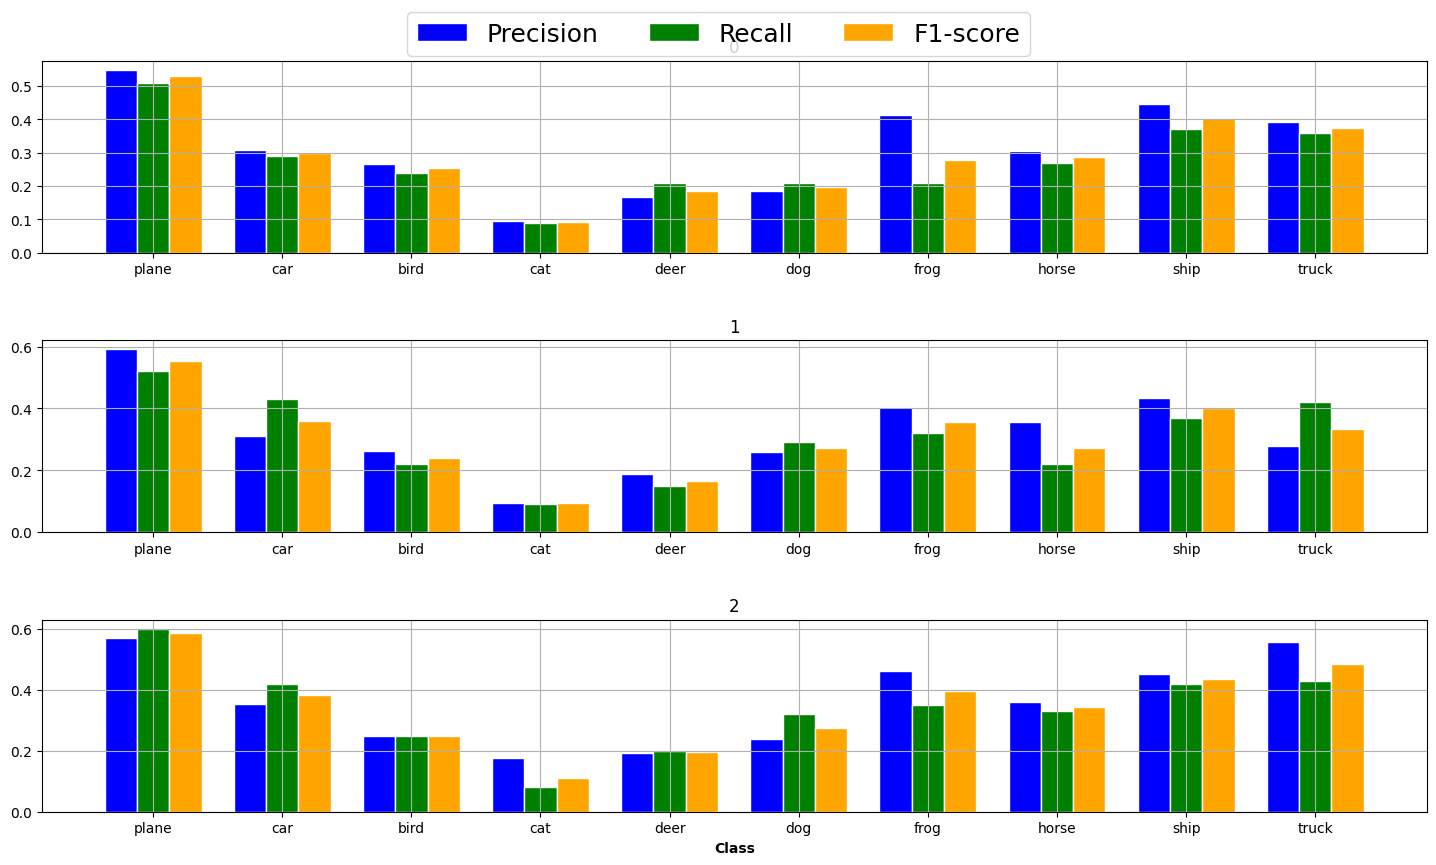

In [14]:
fig, axes = plt.subplots(len(in_features), 1, figsize=(15, 9))
class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
axes = axes.ravel()
bar_width = 0.25
for i, ax in enumerate(axes):
    precisions = result_dict[i]['precision']
    recall = result_dict[i]['recall']
    f1 = result_dict[i]['f1']
    r1 = np.arange(len(precisions))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    ax.bar(r1, precisions, color='blue', width=bar_width, edgecolor='white', label='Precision')
    ax.bar(r2, recall, color='green', width=bar_width, edgecolor='white', label='Recall')
    ax.bar(r3, f1, color='orange', width=bar_width, edgecolor='white', label='F1-score')
    ax.set_title(str(i))
    ax.set_xticks([r + bar_width for r in range(len(precisions))], class_names)
    ax.grid()
plt.xlabel('Class', fontweight='bold')
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol=3, fontsize=18)
plt.tight_layout(pad=3)
plt.show()

In [15]:
ind_accuracies = []
for i, accuracy in enumerate(result_dict['accuracy']):
    accuracy = round(accuracy, 4)
    precision = round(np.mean(result_dict[i]["precision"]), 4)
    recall = round(np.mean(result_dict[i]["recall"]), 4)
    f1 = round(np.mean(result_dict[i]["f1"]), 4)
    ind_accuracies.append(accuracy)
    print(f'Layer {i+1}: Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | f1-score: {f1}')    

Layer 1: Accuracy: 0.2919 | Precision: 0.312 | Recall: 0.276 | f1-score: 0.2897
Layer 2: Accuracy: 0.3262 | Precision: 0.3178 | Recall: 0.303 | f1-score: 0.3049
Layer 3: Accuracy: 0.3499 | Precision: 0.3612 | Recall: 0.34 | f1-score: 0.3461


In [16]:
result_dict = {}
result_dict["accuracy"] = []
in_features = [0]
for ii, in_feature in enumerate(in_features):
    precisions, recall, f1 = [], [], []
    learning_rate = 1e-3
    exit_model = GeneralEEModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(exit_model.parameters(), lr=learning_rate, momentum=0.9)
    epochs = 100
    ee_model_name = "gen_ee_cifar100_s.h5"
    train(baseline, exit_model, ii, epochs, criterion, optimizer, 
          train_loader, val_loader, ee_model_name, gen_ee=True)
    exit_model.load_state_dict(torch.load(ee_model_name, map_location='cpu'))
    exit_model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): 
        true_y, pred_y = [], []
        for i, data in enumerate(test_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            outs, _ = simulate_exit(outs)
            outputs = exit_model(outs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_y = pred_y + list(predicted.detach().cpu().numpy())
            true_y = true_y + list(labels.detach().cpu().numpy())
        report = classification_report(true_y, pred_y, output_dict=True)
        result_dict["accuracy"].append(report["accuracy"])
        for i, (key, value) in enumerate(report.items()):
            if i < 10:
                precisions.append(value['precision'])
                recall.append(value['recall'])
                f1.append(value['f1-score'])
        result_dict[ii] = {
            'precision': precisions,
            'recall': recall,
            'f1': f1,
            'conf_mat': confusion_matrix(true_y, pred_y)
        }

Epoch[1]: t_loss: 4.51951 t_acc: 3.10667 v_loss: 4.42565 v_acc: 5.18
Epoch[2]: t_loss: 4.35497 t_acc: 6.22 v_loss: 4.26722 v_acc: 7.96
Epoch[3]: t_loss: 4.14333 t_acc: 8.88222 v_loss: 4.03885 v_acc: 10.32
Epoch[4]: t_loss: 3.95943 t_acc: 11.05778 v_loss: 3.93763 v_acc: 10.98
Epoch[5]: t_loss: 3.81606 t_acc: 13.48444 v_loss: 3.83932 v_acc: 12.36
Epoch[6]: t_loss: 3.70939 t_acc: 14.85556 v_loss: 3.67505 v_acc: 14.64
Epoch[7]: t_loss: 3.63222 t_acc: 16.30889 v_loss: 3.62368 v_acc: 15.44
Epoch[8]: t_loss: 3.55678 t_acc: 17.30889 v_loss: 3.64709 v_acc: 14.94
Epoch[9]: t_loss: 3.4985 t_acc: 18.25111 v_loss: 3.52813 v_acc: 16.64
Epoch[10]: t_loss: 3.4465 t_acc: 19.18889 v_loss: 3.50095 v_acc: 17.66
Epoch[11]: t_loss: 3.41616 t_acc: 19.88222 v_loss: 3.48543 v_acc: 17.28
Epoch[12]: t_loss: 3.36649 t_acc: 20.63333 v_loss: 3.37605 v_acc: 19.06
Epoch[13]: t_loss: 3.3273 t_acc: 21.36667 v_loss: 3.35256 v_acc: 19.74
Epoch[14]: t_loss: 3.31387 t_acc: 21.78889 v_loss: 3.31758 v_acc: 20.86
Epoch[15]: t

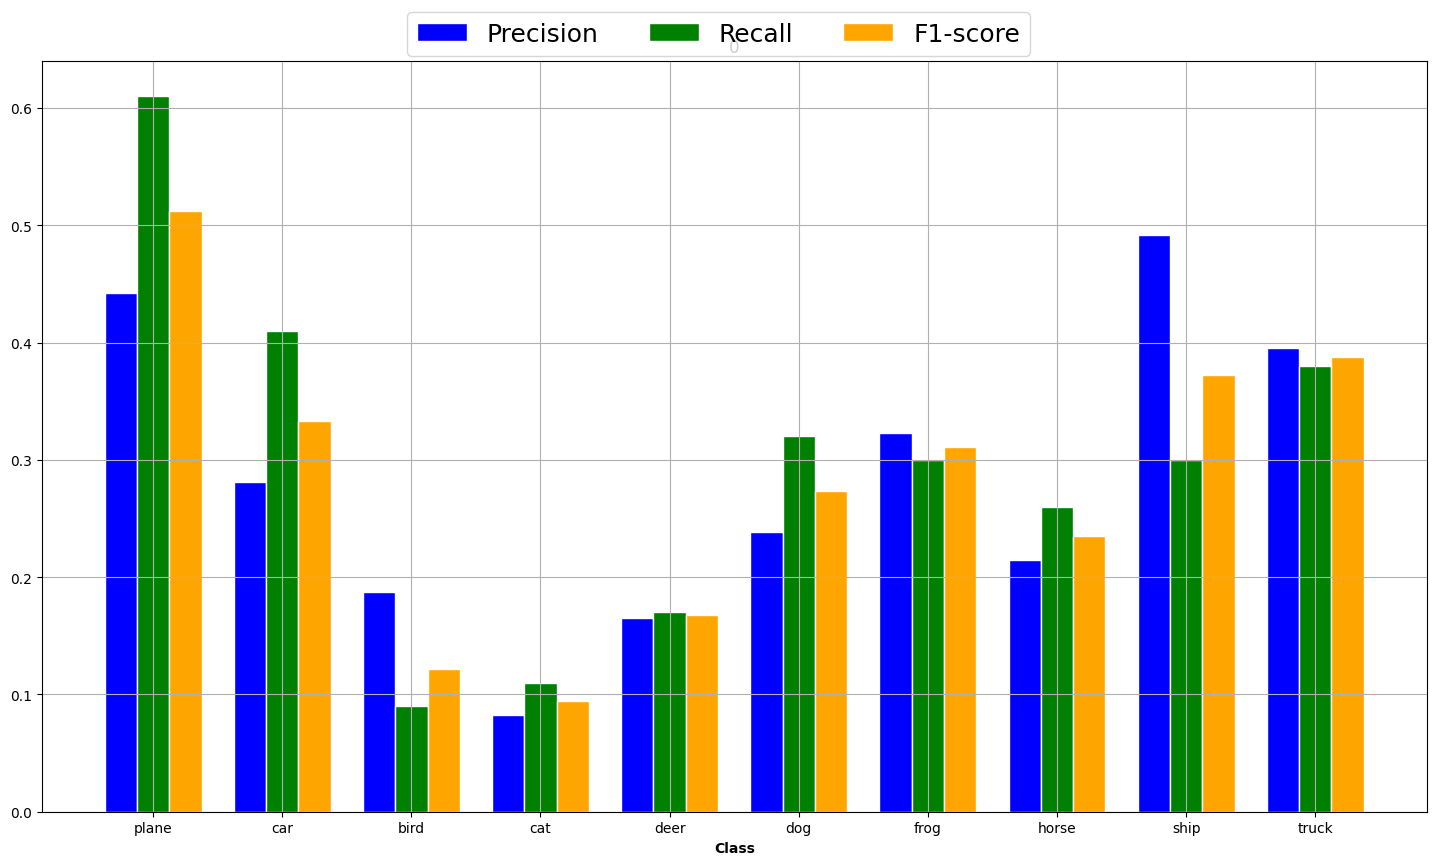

In [17]:
fig, ax = plt.subplots(len(in_features), 1, figsize=(15, 9))
class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
bar_width = 0.25
i = 0
precisions = result_dict[i]['precision']
recall = result_dict[i]['recall']
f1 = result_dict[i]['f1']
r1 = np.arange(len(precisions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
ax.bar(r1, precisions, color='blue', width=bar_width, edgecolor='white', label='Precision')
ax.bar(r2, recall, color='green', width=bar_width, edgecolor='white', label='Recall')
ax.bar(r3, f1, color='orange', width=bar_width, edgecolor='white', label='F1-score')
ax.set_title(str(i))
ax.set_xticks([r + bar_width for r in range(len(precisions))], class_names)
ax.grid()
plt.xlabel('Class', fontweight='bold')
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol=3, fontsize=18)
plt.tight_layout(pad=3)
plt.show()

In [18]:
accuracies = []
for choice in range(3):
    true_y, pred_y = [], []
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        _, outs = baseline(images)
        outs, _ = simulate_exit(outs, choice=i)
        outputs = exit_model(outs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_y = pred_y + list(predicted.detach().cpu().numpy())
        true_y = true_y + list(labels.detach().cpu().numpy())
    report = classification_report(true_y, pred_y, output_dict=True)
    accuracies.append(report["accuracy"])
    print(f'Layer: {choice+1} | Accuracy: {report["accuracy"]}')

Layer: 1 | Accuracy: 0.3256
Layer: 2 | Accuracy: 0.3256
Layer: 3 | Accuracy: 0.325


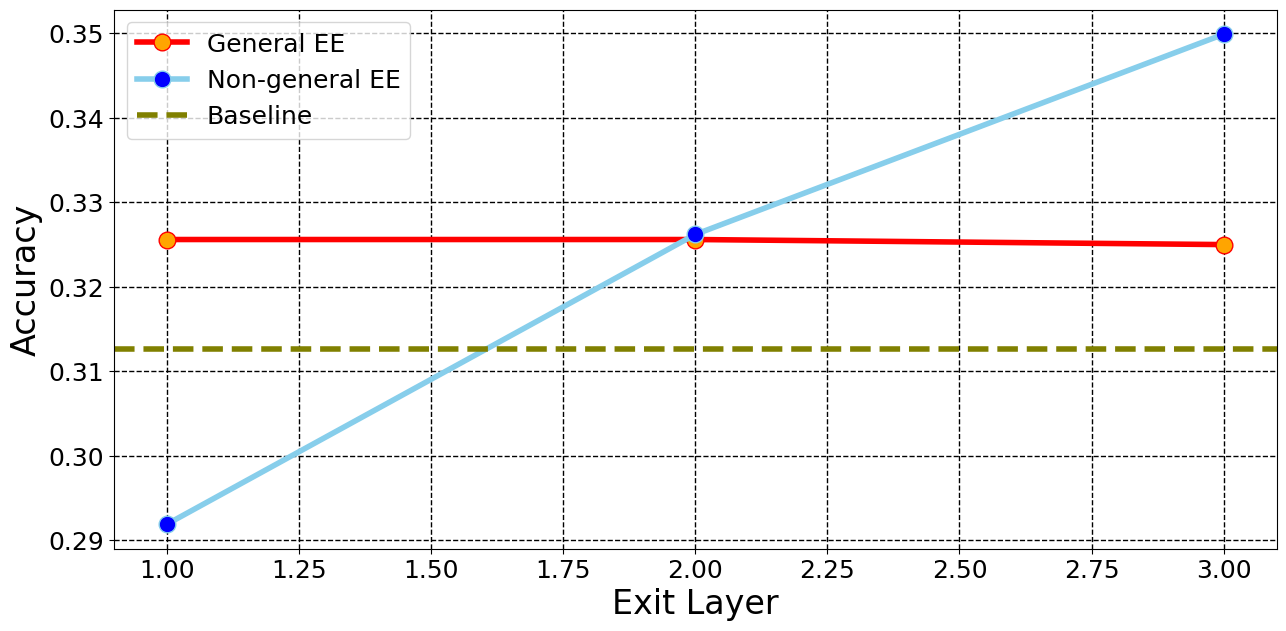

In [19]:
plt.figure(figsize=(15, 7))
x = [1, 2, 3]
plt.plot(x, accuracies, 
         marker='o', markerfacecolor='orange', markersize=12, color='red', linewidth=4,
         label="General EE"
        )
plt.plot(x, ind_accuracies, 
         marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,
         label="Non-general EE"
        )
plt.axhline(0.3126, marker='', color='olive', linewidth=4, linestyle='dashed', label="Baseline")
plt.xlabel("Exit Layer", fontsize=24)
plt.ylabel("Accuracy", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(color='k', linestyle='--', linewidth=1)
plt.legend(loc="best", prop={'size': 18})
plt.show()